# Project 7: Time Series 
* Get the data from www.ecad.eu and do future predictions with lenear regression
* Output: Prediction of the temperature on 01.07.2022

---

## Import the necessary libraries and read the data

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.ar_model import AutoReg
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

data = pd.read_csv("TG_STAID002759.txt", skiprows=19)

data.head(5)

,SOUID,DATE,TG,Q_TG
0,127488,18760101,22,0
1,127488,18760102,25,0
2,127488,18760103,3,0
3,127488,18760104,-58,0
4,127488,18760105,-98,0


## Remove unnecessary columns

In [2]:
data.drop("SOUID",axis=1, inplace=True)
data.drop("Q_TG",axis=1, inplace=True)
data.head(5)

,DATE,TG
0,18760101,22
1,18760102,25
2,18760103,3
3,18760104,-58
4,18760105,-98


# Apply imputation to the missing values by taking average of years

In [3]:
date = data['DATE']
data1 = data.copy()
data1.set_index('DATE',inplace=True)
date_u = []
tem = data['TG']

for index, row in data.iterrows():
    s1 = str(date[index])
    s1_year = s1[0:4]
    s1_month = s1[4:6]
    s1_day = s1[6:8]

    #print(index,tem[index])
    s1_year_int = int(s1_year)
    data.at[index,'DATE'] = s1_year+'-'+s1_month+'-'+s1_day
    if tem[index] == -9999:
        #print(index)
        s1_b1 = int(str(s1_year_int - 1) + s1_month + s1_day)
        s1_b2 = int(str(s1_year_int - 2) + s1_month + s1_day)
        s1_b3 = int(str(s1_year_int - 3) + s1_month + s1_day)
        s1_f1 = int(str(s1_year_int + 1) + s1_month + s1_day)
        s1_f2 = int(str(s1_year_int + 2) + s1_month + s1_day)
        s1_f3 = int(str(s1_year_int + 3) + s1_month + s1_day)
        
        t1 = data1.loc[s1_b1,'TG']
        t2 = data1.loc[s1_b2,'TG']
        t3 = data1.loc[s1_b3,'TG']
        t4 = data1.loc[s1_f1,'TG']
        t5 = data1.loc[s1_f2,'TG']
        t6 = data1.loc[s1_f3,'TG']
        
        avr = (t1 + t2 + t3 +t4 +t5 + t6)/6
        #print(avr)
        data.at[index,'TG'] = avr
        #print(data1.loc[s1_b1,'TG'])
        #avr = (tem[s1_b1] + tem[s1_b2] + tem[s1_b3] + tem[s1_f1] + tem[s1_f2]+ tem[s1_f3])/6 
        #data.at[index,'TG'] = avr
        #print(avr)
        
        #print(row['DATE'], row['TG'])
    
#data.head(5) 
data['TG'] =data['TG']/10
data

,DATE,TG
0,1876-01-01,2.2
1,1876-01-02,2.5
2,1876-01-03,0.3
3,1876-01-04,-5.8
4,1876-01-05,-9.8
...,...,...
53502,2022-06-26,26.3
53503,2022-06-27,28.1
53504,2022-06-28,21.4
53505,2022-06-29,21.4


In [4]:
# Conver 'DATE' column to datetime
data['DATE']= pd.to_datetime(data['DATE'])
data.set_index('DATE', inplace=True)
data

,TG
DATE,
1876-01-01,2.2
1876-01-02,2.5
1876-01-03,0.3
1876-01-04,-5.8
1876-01-05,-9.8
...,...
2022-06-26,26.3
2022-06-27,28.1
2022-06-28,21.4


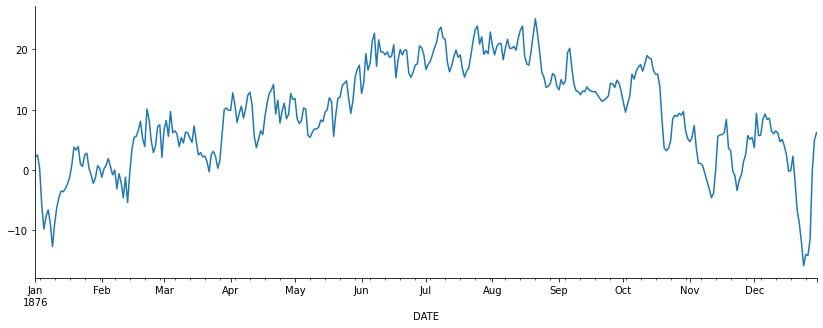

In [5]:
# plot temperature for the first year
data['TG'][:365].plot(figsize=(14,5))
sns.despine()

# Extract the Timestep and the Seasonal Dummies for the whole Dataset

In [6]:
# Create a timestep variable
data['timestep'] = list(range(len(data)))
data.head()

,TG,timestep
DATE,,
1876-01-01,2.2,0
1876-01-02,2.5,1
1876-01-03,0.3,2
1876-01-04,-5.8,3
1876-01-05,-9.8,4


In [7]:
# Create the seasonal dummies
seasonal_dummies = pd.get_dummies(data.index.month,
                                  prefix='month',
                                  drop_first=True).set_index(data.index)

data = data.join(seasonal_dummies)
data.head()

,TG,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
DATE,,,,,,,,,,,,,
1876-01-01,2.2,0,0,0,0,0,0,0,0,0,0,0,0
1876-01-02,2.5,1,0,0,0,0,0,0,0,0,0,0,0
1876-01-03,0.3,2,0,0,0,0,0,0,0,0,0,0,0
1876-01-04,-5.8,3,0,0,0,0,0,0,0,0,0,0,0
1876-01-05,-9.8,4,0,0,0,0,0,0,0,0,0,0,0


# Train-Test-Split

In [8]:
data_combined = data 


data_train = data[:-365]


data_test = data[-365:]



In [9]:
# Define X and y

X = data_train.drop(columns=['TG'])

y = data_train['TG']


In [10]:
# Create and fit the model
m = LinearRegression()
m.fit(X,y)

LinearRegression()

In [11]:
# Create a new column with the predictions of the trend_seasonal model


data_train['trend_seasonal'] = m.predict(X)
data_train

/tmp/ipykernel_395794/2230668113.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['trend_seasonal'] = m.predict(X)


,TG,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal
DATE,,,,,,,,,,,,,,
1876-01-01,2.2,0,0,0,0,0,0,0,0,0,0,0,0,-0.871287
1876-01-02,2.5,1,0,0,0,0,0,0,0,0,0,0,0,-0.871255
1876-01-03,0.3,2,0,0,0,0,0,0,0,0,0,0,0,-0.871222
1876-01-04,-5.8,3,0,0,0,0,0,0,0,0,0,0,0,-0.871189
1876-01-05,-9.8,4,0,0,0,0,0,0,0,0,0,0,0,-0.871157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-26,21.5,53137,0,0,0,0,1,0,0,0,0,0,0,18.198312
2021-06-27,22.1,53138,0,0,0,0,1,0,0,0,0,0,0,18.198345
2021-06-28,25.3,53139,0,0,0,0,1,0,0,0,0,0,0,18.198378


# Plot the original data and preliminary model¶

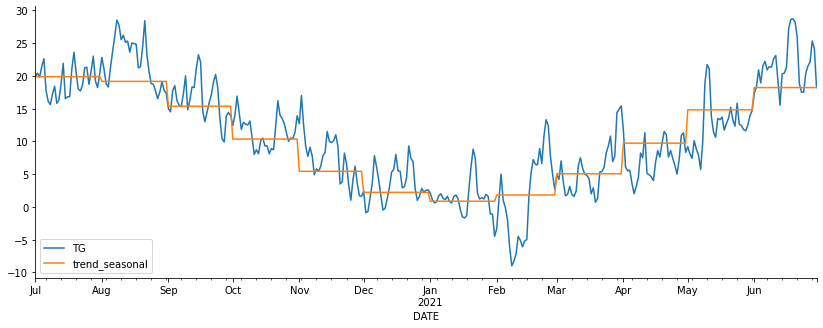

In [12]:
# plot temperature of the last year of the test data
data_train[['TG', 'trend_seasonal']][-365:].plot(figsize=(14,5))
sns.despine()

# Extract the remainder

In [13]:
#We want to extract the part of the model that the trend_seasonal is not able to explain

data_train['remainder'] = data_train['TG'] - data_train['trend_seasonal']

/tmp/ipykernel_395794/1714661776.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['remainder'] = data_train['TG'] - data_train['trend_seasonal']


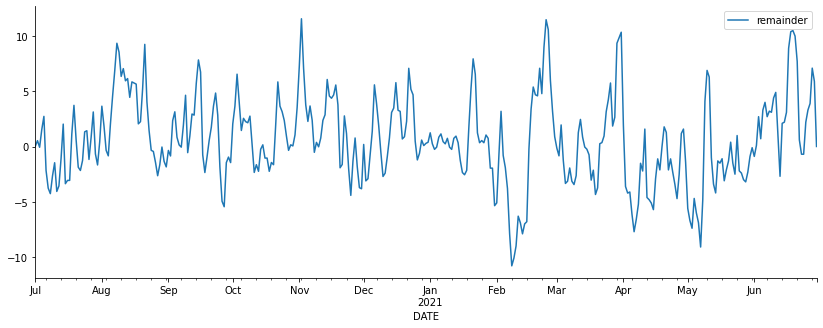

In [14]:
# plot the remainder 
data_train[['remainder']][-365:].plot(figsize=(14,5))
sns.despine()

# Inspect the remainder to decide how many lags to include

Figure(432x288)


/home/kaya/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


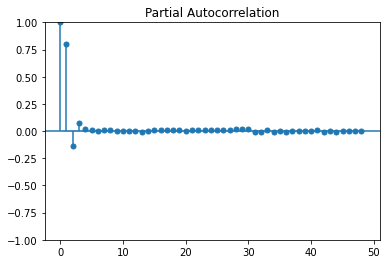

In [15]:

print(plot_pacf(data_train['remainder']))


In [16]:
from statsmodels.tsa.ar_model import ar_select_order

selected_order = ar_select_order(data_train['remainder'], maxlag = 12)
selected_order.ar_lags

/home/kaya/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/kaya/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


[1, 2, 3, 4]

# Get predictions for the combied data

In [17]:
data['trend_seasonal'] = m.predict(data.drop(columns=['TG']))
data

,TG,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal
DATE,,,,,,,,,,,,,,
1876-01-01,2.2,0,0,0,0,0,0,0,0,0,0,0,0,-0.871287
1876-01-02,2.5,1,0,0,0,0,0,0,0,0,0,0,0,-0.871255
1876-01-03,0.3,2,0,0,0,0,0,0,0,0,0,0,0,-0.871222
1876-01-04,-5.8,3,0,0,0,0,0,0,0,0,0,0,0,-0.871189
1876-01-05,-9.8,4,0,0,0,0,0,0,0,0,0,0,0,-0.871157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-26,26.3,53502,0,0,0,0,1,0,0,0,0,0,0,18.210231
2022-06-27,28.1,53503,0,0,0,0,1,0,0,0,0,0,0,18.210264
2022-06-28,21.4,53504,0,0,0,0,1,0,0,0,0,0,0,18.210297


# Extract remainder for the test data

In [18]:
data['remainder'] = data['TG'] - data['trend_seasonal']

In [19]:
data['lag1'] = data['remainder'].shift(1)
data['lag2'] = data['remainder'].shift(2)
data['lag3'] = data['remainder'].shift(3)
data['lag4'] = data['remainder'].shift(4)
data.dropna(inplace=True)
data.head()

,TG,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1,lag2,lag3,lag4
DATE,,,,,,,,,,,,,,,,,,,
1876-01-05,-9.8,4,0,0,0,0,0,0,0,0,0,0,0,-0.871157,-8.928843,-4.928811,1.171222,3.371255,3.071287
1876-01-06,-7.7,5,0,0,0,0,0,0,0,0,0,0,0,-0.871124,-6.828876,-8.928843,-4.928811,1.171222,3.371255
1876-01-07,-6.6,6,0,0,0,0,0,0,0,0,0,0,0,-0.871091,-5.728909,-6.828876,-8.928843,-4.928811,1.171222
1876-01-08,-8.9,7,0,0,0,0,0,0,0,0,0,0,0,-0.871059,-8.028941,-5.728909,-6.828876,-8.928843,-4.928811
1876-01-09,-12.7,8,0,0,0,0,0,0,0,0,0,0,0,-0.871026,-11.828974,-8.028941,-5.728909,-6.828876,-8.928843


# Run the full model

In [20]:
# Assign X
X_full = data.drop(columns=['TG', 'trend_seasonal', 'remainder'])[:-361]
y_full = data['TG'][:-361]


In [21]:
m_full = LinearRegression()
m_full.fit(X_full, y_full)

LinearRegression()

In [22]:
# Create a new predictions for the combined data column
data['predictions_full_model'] = m_full.predict(data.drop(columns=['TG', 'trend_seasonal', 'remainder']))
data

,TG,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1,lag2,lag3,lag4,predictions_full_model
DATE,,,,,,,,,,,,,,,,,,,,
1876-01-05,-9.8,4,0,0,0,0,0,0,0,0,0,0,0,-0.871157,-8.928843,-4.928811,1.171222,3.371255,3.071287,-5.363259
1876-01-06,-7.7,5,0,0,0,0,0,0,0,0,0,0,0,-0.871124,-6.828876,-8.928843,-4.928811,1.171222,3.371255,-7.975068
1876-01-07,-6.6,6,0,0,0,0,0,0,0,0,0,0,0,-0.871091,-5.728909,-6.828876,-8.928843,-4.928811,1.171222,-5.642049
1876-01-08,-8.9,7,0,0,0,0,0,0,0,0,0,0,0,-0.871059,-8.028941,-5.728909,-6.828876,-8.928843,-4.928811,-5.357558
1876-01-09,-12.7,8,0,0,0,0,0,0,0,0,0,0,0,-0.871026,-11.828974,-8.028941,-5.728909,-6.828876,-8.928843,-7.635714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-26,26.3,53502,0,0,0,0,1,0,0,0,0,0,0,18.210231,8.089769,5.689801,7.189834,5.389866,3.089899,22.358955
2022-06-27,28.1,53503,0,0,0,0,1,0,0,0,0,0,0,18.210264,9.889736,8.089769,5.689801,7.189834,5.389866,24.991263
2022-06-28,21.4,53504,0,0,0,0,1,0,0,0,0,0,0,18.210297,3.189703,9.889736,8.089769,5.689801,7.189834,26.129394


# Plot the prediction vs temperature for the test data

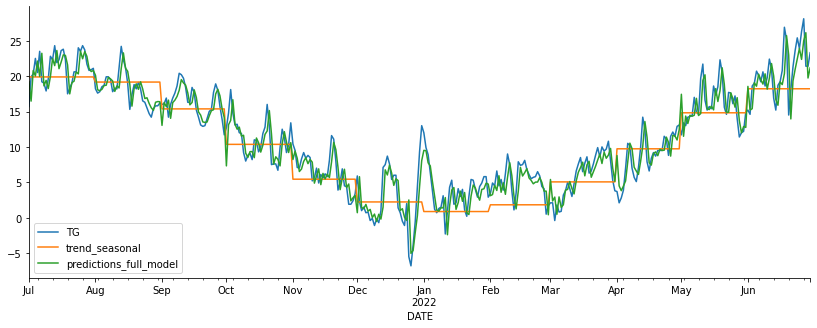

In [23]:
data[['TG', 'trend_seasonal','predictions_full_model']][-365:].plot(figsize=(14,5))
sns.despine()

# Evaluate our model

In [24]:
# Create a TimeSeriesSplit object
from sklearn.model_selection import TimeSeriesSplit
ts_split = TimeSeriesSplit(n_splits=5)

In [25]:
# Split the training data into folds
for i, (train_index, validation_index) in enumerate(ts_split.split(X_full, y_full)):
    print(f"""The training data for the {i+1}th iteration are the observations steps 
    {train_index}""")
    print(f"""The validation data for the {i+1}th iteration are the observations steps
    {validation_index}""")
    print('\n')

The training data for the 1th iteration are the observations steps 
    [   0    1    2 ... 8854 8855 8856]
The validation data for the 1th iteration are the observations steps
    [ 8857  8858  8859 ... 17711 17712 17713]


The training data for the 2th iteration are the observations steps 
    [    0     1     2 ... 17711 17712 17713]
The validation data for the 2th iteration are the observations steps
    [17714 17715 17716 ... 26568 26569 26570]


The training data for the 3th iteration are the observations steps 
    [    0     1     2 ... 26568 26569 26570]
The validation data for the 3th iteration are the observations steps
    [26571 26572 26573 ... 35425 35426 35427]


The training data for the 4th iteration are the observations steps 
    [    0     1     2 ... 35425 35426 35427]
The validation data for the 4th iteration are the observations steps
    [35428 35429 35430 ... 44282 44283 44284]


The training data for the 5th iteration are the observations steps 
    [    0    

In [26]:
# Create the time series split
time_series_split = ts_split.split(X_full, y_full) 

In [27]:
# Do the cross validation: Remember these are the 'test scores' in the training data.
from sklearn.model_selection import cross_val_score
result = cross_val_score(estimator=m_full, 
                         X=X_full, y=y_full,
                         cv=time_series_split)
result

array([0.90481572, 0.91366742, 0.9136053 , 0.90891245, 0.91793689])

#  Predict the future

In [28]:
# Re-train the model on the whole dataset
X_combined = data.drop(columns=['TG', 'trend_seasonal', 'remainder', 'predictions_full_model'])
y_combined = data['TG']

In [29]:
m_combined = LinearRegression()
m_combined.fit(X_combined, y_combined)

LinearRegression()

# create a future step data

In [30]:
data.tail()

,TG,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1,lag2,lag3,lag4,predictions_full_model
DATE,,,,,,,,,,,,,,,,,,,,
2022-06-26,26.3,53502,0,0,0,0,1,0,0,0,0,0,0,18.210231,8.089769,5.689801,7.189834,5.389866,3.089899,22.358955
2022-06-27,28.1,53503,0,0,0,0,1,0,0,0,0,0,0,18.210264,9.889736,8.089769,5.689801,7.189834,5.389866,24.991263
2022-06-28,21.4,53504,0,0,0,0,1,0,0,0,0,0,0,18.210297,3.189703,9.889736,8.089769,5.689801,7.189834,26.129394
2022-06-29,21.4,53505,0,0,0,0,1,0,0,0,0,0,0,18.210329,3.189671,3.189703,9.889736,8.089769,5.689801,19.730480
2022-06-30,23.3,53506,0,0,0,0,1,0,0,0,0,0,0,18.210362,5.089638,3.189671,3.189703,9.889736,8.089769,21.164282


In [31]:
timestep = data['timestep'].max() + 1
months = [0] * 11
months[5] = 1
lag1 = data.loc['2022-06-30', 'remainder']
lag2 = data.loc['2022-06-30', 'lag1']
lag3 = data.loc['2022-06-30', 'lag2']
lag4 = data.loc['2022-06-30', 'lag3']


In [32]:
X_future = [timestep]

X_future.extend(months)

X_future.append(lag1)
X_future.append(lag2)
X_future.append(lag3)
X_future.append(lag4)

#X_future

In [33]:
X_future = pd.DataFrame([X_future]) 
X_future.columns = X_full.columns
#X_full.columns

#X_future

In [34]:
X_future

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1,lag2,lag3,lag4
0,53507,0,0,0,0,0,1,0,0,0,0,0,5.089638,3.189671,3.189703,9.889736


In [35]:
m_combined.predict(X_future)

array([24.28492619])

# The temperature prediction of the model for 01.07.2022 is 24.28